In [8]:
# --- Librairies --- #


import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from typing import Callable, Tuple

In [11]:
# --- Functions : laws --- #


def linear_law(time: np.ndarray, velocity: float, constant: float) -> np.ndarray:
    """
    Linear law: y = v * t + c

    Args:
        time (np.ndarray): Array of time values.
        velocity (float): Linear velocity coefficient.
        constant (float): Constant offset.

    Returns:
        np.ndarray: Computed linear law values.
    """
    return velocity * time + constant


def power_law(time: np.ndarray, coefficient: float, exponent: float) -> np.ndarray:
    """
    Power law: y = a * (x)**b

    Args:
        time (np.ndarray): Array of time values.
        coefficient (float): Scaling coefficient (a).
        exponent (float): Exponent value (b).

    Returns:
        np.ndarray: Computed power law values.
    """
    return coefficient * (time ** exponent)


def logarithm_law(time: np.ndarray, coefficient: float, exponent: float) -> np.ndarray:
    """
    Logarithmic law: y = a * ln(1 + x)**b

    Args:
        time (np.ndarray): Array of time values.
        coefficient (float): Scaling coefficient (a).
        exponent (float): Exponent value (b).

    Returns:
        np.ndarray: Computed logarithmic law values.
    """
    return coefficient * (np.log(time + 1) ** exponent)


def combined_linear_and_power_law(
    time: np.ndarray, 
    velocity: float, 
    coefficient: float, 
    diffusion: float, 
    inflection: float, 
    stiffness: float
) -> np.ndarray:
    """
    Combination of linear and power laws:
    y = [(v * t) / (1 + (t / inflection)**stiffness)] 
        + [((t / inflection)**stiffness) / (1 + (t / inflection)**stiffness)] * (coefficient * t**diffusion)

    Args:
        time (np.ndarray): Array of time values. (t)
        velocity (float): Linear velocity coefficient. (v)
        coefficient (float): Coefficient for the power law term. (D)
        diffusion (float): Exponent for the power law term. (w)
        inflection (float): Time value of transition between linear and power behavior. (tau)
        stiffness (float): Controls the sharpness of the transition between linear and power behavior. (h)

    Returns:
        np.ndarray: Computed combined law values.
    """
    term = 1 / (1 + (time / inflection) ** stiffness)
    linear_term = (velocity * time) * term
    power_term = (coefficient * time ** diffusion) * (1 - term)
    return linear_term + power_term


# --- Functions : fitting --- #


def filtering_before_fit(
    time: np.ndarray, 
    data: np.ndarray, 
    std: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Filters the input arrays to remove invalid or problematic data points before fitting.

    Args:
        time (np.ndarray): Array of time values.
        data (np.ndarray): Array of data values.
        std (np.ndarray): Array of standard deviation values.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Filtered time, data, and standard deviation arrays.
    """
    # Convert inputs to NumPy arrays if they are not already
    time = np.array(time)
    data = np.array(data)
    std = np.array(std)

    # Filter out NaN, infinite values, and invalid data points
    valid_idx = ~np.isnan(data) & ~np.isnan(std) & ~np.isinf(data) & ~np.isinf(std)
    time = time[valid_idx]
    data = data[valid_idx]
    std = std[valid_idx]

    # Replace standard deviations of 0 with a small positive value
    std = np.where(std == 0, 1e-10, std)

    return time, data, std


def fitting_in_superposition(positions, deviations, tmax, time_step, plot=False):


    times = np.arange(0, tmax, time_step)

    # raising error if non-sense
    if len(positions) != len(deviations):
        raise ValueError("Errors from the datas : positions and deviations have not the same lenght.")
    elif len(positions) != tmax :
        raise ValueError("Errors from the datas : positions lenght is not equal to tmax.")


    # filtering the datas
    times, positions, deviations = filtering_before_fit(times, positions, deviations)


    # first fit : linear law
    borne_min_v, borne_max_v = 0, 1e3
    borne_min_c, borne_max_c = 0, 1e-3
    bounds_linear = ([borne_min_v, borne_min_c,], [borne_max_v, borne_max_c])

    fit_params_linear, fit_errors_linear = curve_fit(f=linear_law, xdata=times, ydata=positions, sigma=deviations, bounds=bounds_linear)
    v0 = fit_params_linear[0]
    c0 = fit_params_linear[1]
    fitted_data_linear = linear_law(times, *fit_params_linear)
    # print(f'v={v0} and c={c0}')


    # second fit : power law
    borne_min_D, borne_max_D = 0, 1e1
    borne_min_w, borne_max_w = 0, 1e1
    bounds_power = ([borne_min_D, borne_min_w,], [borne_max_D, borne_max_w])

    fit_params_power, fit_errors_power = curve_fit(f=power_law, xdata=times, ydata=positions, sigma=deviations, bounds=bounds_power)
    D0 = fit_params_power[0]
    w0 = fit_params_power[1]
    fitted_data_power = power_law(times, *fit_params_power)
    # print(f'D={D0} and w={w0}')


    # third fit : using the precedent ones : v - d - w - tau - h
    borne_min_v, borne_max_v = v0, 3*v0
    borne_min_D, borne_max_D = D0/2, 2*D0
    borne_min_w, borne_max_w = w0/2, 2*w0
    borne_min_tau, borne_max_tau = 0, tmax
    borne_min_h, borne_max_h = 2, 1e2

    bounds_params = ([borne_min_v, borne_min_D, borne_min_w, borne_min_tau, borne_min_h],
                    [borne_max_D, borne_max_D, borne_max_w, borne_max_tau, borne_max_h])

    deviations = np.multiply(deviations, 1/tmax)
    popt, pcov = curve_fit(f=combined_linear_and_power_law, xdata=times, ydata=positions, sigma=deviations, bounds=bounds_params)
    v, D, w, tau, h = popt
    fitted_data = combined_linear_and_power_law(times, *popt)

    # plot or not
    if plot :
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))

        # Subplot 1
        axes[0].errorbar(times, positions, yerr=deviations, fmt='o', color='gray', alpha=0.25, label="Datas")
        axes[0].scatter(times, fitted_data_linear, label=f"{'linear_law'}", marker='+', alpha=1)
        axes[0].scatter(times, fitted_data_power, label=f"{'power_law'}", marker='+', alpha=1)
        axes[0].scatter(times, fitted_data, label=f'linear+power', marker='+', c='r')
        axes[0].set_title("Cartesian scale")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Position")
        axes[0].grid(True, which="both")
        axes[0].legend()
        
        # Subplot 2
        axes[1].errorbar(times, positions, yerr=deviations, fmt='o', color='gray', alpha=0.25, label="Datas")
        axes[1].scatter(times, fitted_data_linear, label=f"{'linear_law'}", marker='+', alpha=1)
        axes[1].scatter(times, fitted_data_power, label=f"{'power_law'}", marker='+', alpha=1)
        axes[1].scatter(times, fitted_data, label=f'linear+power', marker='+', c='r')
        axes[1].set_title("Loglog scale")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Position")
        axes[1].grid(True, which="both")
        axes[1].legend()
        axes[1].loglog()
        
        # End
        plt.tight_layout()
        plt.show()
    
    return popt, pcov


def fitting_in_two_steps(positions, times, bound_low, bound_high, plot=False):
    

    xt_over_t = np.divide(positions,times)

    array_low = xt_over_t[1:bound_low]
    v = np.sum(array_low) / len(array_low)

    dlogx = np.diff(np.log(positions))
    dlogt = np.diff(np.log(times))
    G = np.divide(dlogx, dlogt)
    G_high = G[bound_high:]
    w = np.sum(G_high) / len(G_high)   
    
    # plot or not
    if plot :
        fig, axes = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle("Fitting Results in Two Steps", fontsize=16)

        # --- Subplot 1: x(t) --- #
        axes[0, 0].plot(times, positions, marker='o', alpha=0.5, label='data', c='b')
        axes[0, 0].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[0, 0].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[0, 0].set_title("x(t) - Cartesian Scale")
        axes[0, 0].set_xlabel("Time (t)")
        axes[0, 0].set_ylabel("Position (x)")
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        axes[0, 1].plot(times, positions, marker='o', alpha=0.5, label='data', c='b')
        axes[0, 1].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[0, 1].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[0, 1].set_title("x(t) - Log-Log Scale")
        axes[0, 1].set_xlabel("Time (t)")
        axes[0, 1].set_ylabel("Position (x)")
        axes[0, 1].loglog()
        axes[0, 1].legend()
        axes[0, 1].grid(True, which="both", linestyle='--')

        # --- Subplot 2: x(t)/t --- #
        axes[1, 0].plot(times, xt_over_t, marker='o', alpha=0.5, label='x(t)/t', c='g')
        axes[1, 0].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[1, 0].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[1, 0].axhline(y=v, c='r', ls=':', label=f'v={np.round(v,2)}')
        axes[1, 0].set_title("x(t)/t - Cartesian Scale")
        axes[1, 0].set_xlabel("Time (t)")
        axes[1, 0].set_ylabel("x(t)/t")
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        axes[1, 1].plot(times, xt_over_t, marker='o', alpha=0.5, label='x(t)/t', c='g')
        axes[1, 1].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[1, 1].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[1, 1].axhline(y=v, c='r', ls=':', label=f'v={np.round(v,2)}')
        axes[1, 1].set_title("x(t)/t - Log-Log Scale")
        axes[1, 1].set_xlabel("Time (t)")
        axes[1, 1].set_ylabel("x(t)/t")
        axes[1, 1].loglog()
        axes[1, 1].legend()
        axes[1, 1].grid(True, which="both", linestyle='--')

        # --- Subplot 3: Logarithmic derivative (G) --- #
        axes[2, 0].plot(times[1:], G, marker='o', alpha=0.5, label='G', c='orange')
        axes[2, 0].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[2, 0].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[2, 0].axhline(y=w, c='r', ls='--', label=f'w={np.round(w,2)}')
        axes[2, 0].set_title("Logarithmic Derivative (G) - Cartesian Scale")
        axes[2, 0].set_xlabel("Time (t)")
        axes[2, 0].set_ylabel("G")
        axes[2, 0].legend()
        axes[2, 0].grid(True)

        axes[2, 1].plot(times[1:], G, marker='o', alpha=0.5, label='G', c='orange')
        axes[2, 1].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[2, 1].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[2, 1].axhline(y=w, c='r', ls='--', label=f'w={np.round(w,2)}')
        axes[2, 1].set_title("Logarithmic Derivative (G) - Log-Log Scale")
        axes[2, 1].set_xlabel("Time (t)")
        axes[2, 1].set_ylabel("G")
        axes[2, 1].loglog()
        axes[2, 1].legend()
        axes[2, 1].grid(True, which="both", linestyle='--')

        # --- Subplot 4: Final Results --- #
        axes[3, 0].plot(times, positions, marker='o', alpha=0.5, label='data', c='b')
        axes[3, 0].plot(times[:bound_low], np.multiply(positions[:bound_low], v), label='linear_fit_1', c='r', ls=':', lw=2)
        axes[3, 0].plot(times[bound_high:], np.power(positions[bound_high:], w), label='linear_fit_2', c='r', ls='--', lw=2)
        axes[3, 0].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[3, 0].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[3, 0].set_title("Final Results - Cartesian Scale")
        axes[3, 0].set_xlabel("Time (t)")
        axes[3, 0].set_ylabel("Position (x)")
        axes[3, 0].legend()
        axes[3, 0].grid(True)

        axes[3, 1].plot(times, positions, marker='o', alpha=0.5, label='data', c='b')
        axes[3, 1].plot(times[:bound_low], np.multiply(positions[:bound_low], v), label='linear_fit_1', c='r', ls=':', lw=2)
        axes[3, 1].plot(times[bound_high:], np.power(positions[bound_high:], w), label='linear_fit_2', c='r', ls='--', lw=2)
        axes[3, 1].axvline(x=bound_low, label=f't={bound_low}', ls=':')
        axes[3, 1].axvline(x=bound_high, label=f't={bound_high}', ls='--')
        axes[3, 1].set_title("Final Results - Log-Log Scale")
        axes[3, 1].set_xlabel("Time (log)")
        axes[3, 1].set_ylabel("Position (log)")
        axes[3, 1].loglog()
        axes[3, 1].legend()
        axes[3, 1].grid(True, which="both", linestyle='--')

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()
    
    return v,w

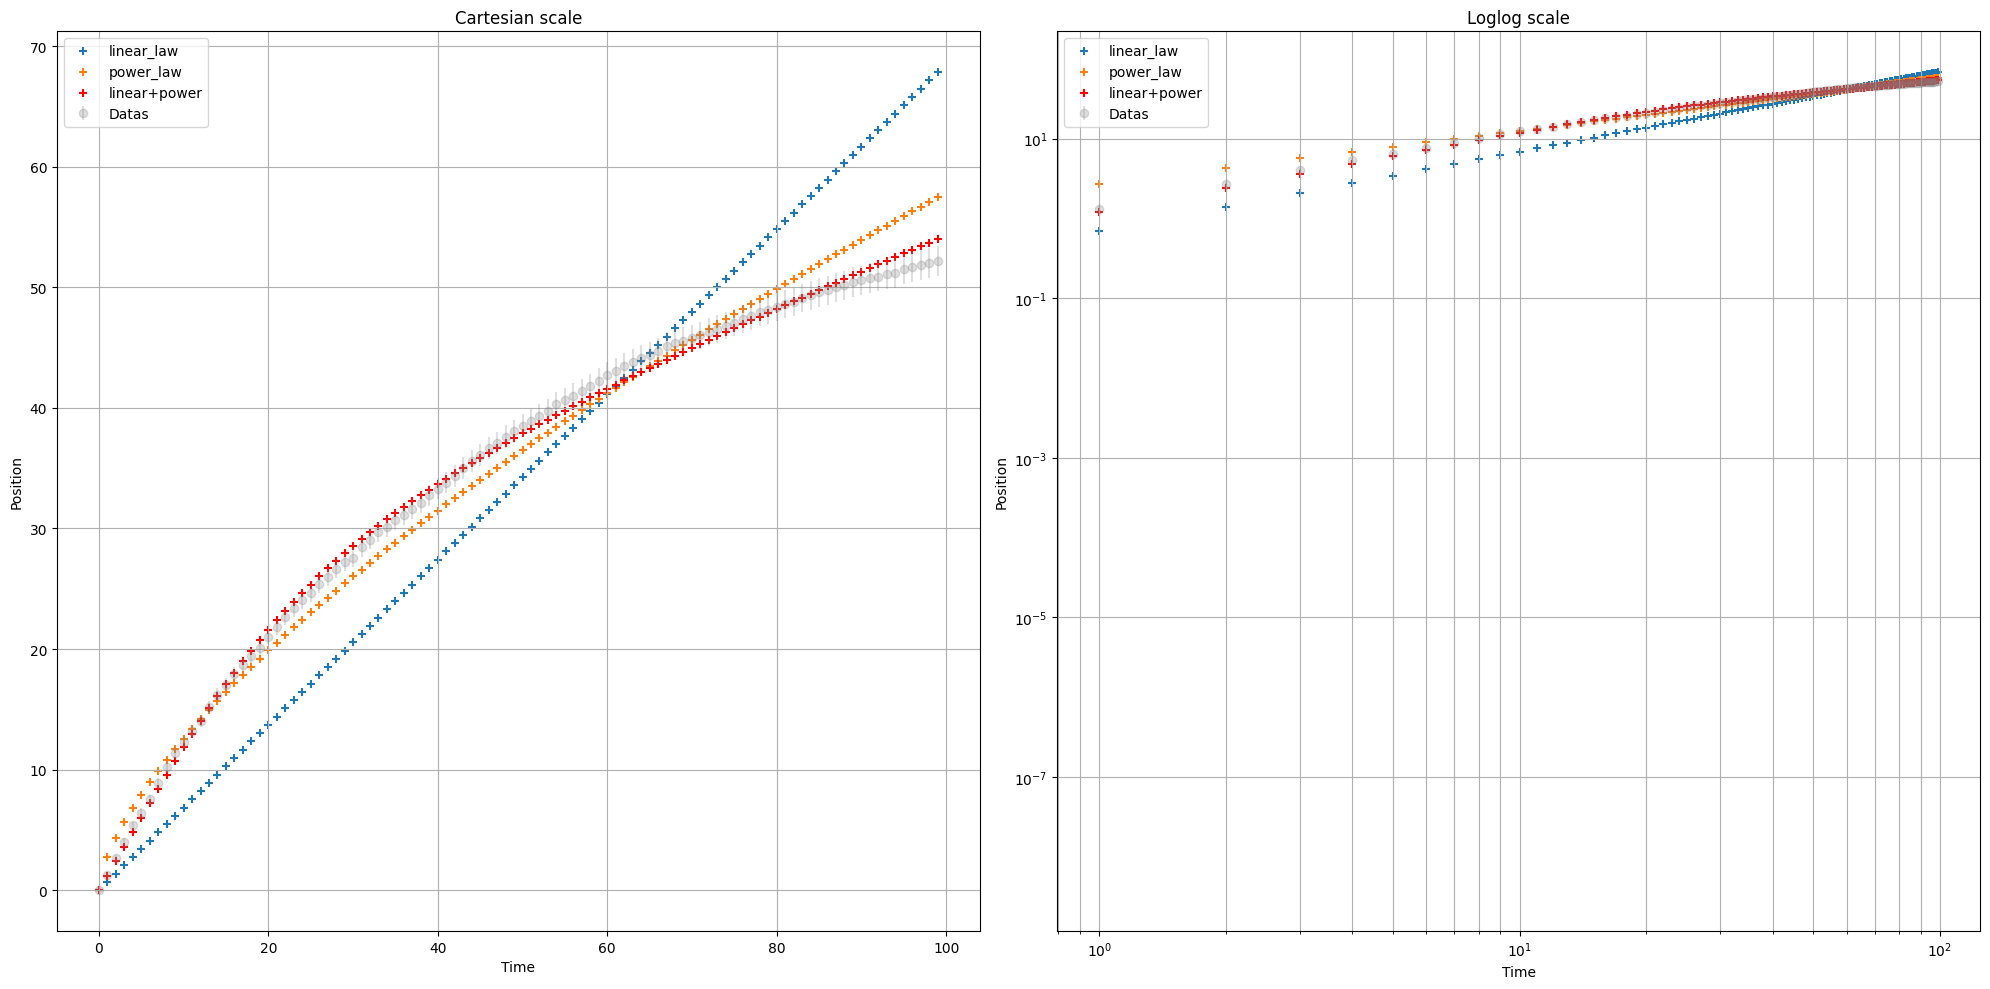

v= 1.199342082524337 
w= 0.660744216660952


/tmp/ipykernel_188133/3212921086.py:207: RuntimeWarning: invalid value encountered in divide
  xt_over_t = np.divide(positions,times)
/tmp/ipykernel_188133/3212921086.py:212: RuntimeWarning: divide by zero encountered in log
  dlogx = np.diff(np.log(positions))
/tmp/ipykernel_188133/3212921086.py:213: RuntimeWarning: divide by zero encountered in log
  dlogt = np.diff(np.log(times))
/tmp/ipykernel_188133/3212921086.py:214: RuntimeWarning: invalid value encountered in divide
  G = np.divide(dlogx, dlogt)


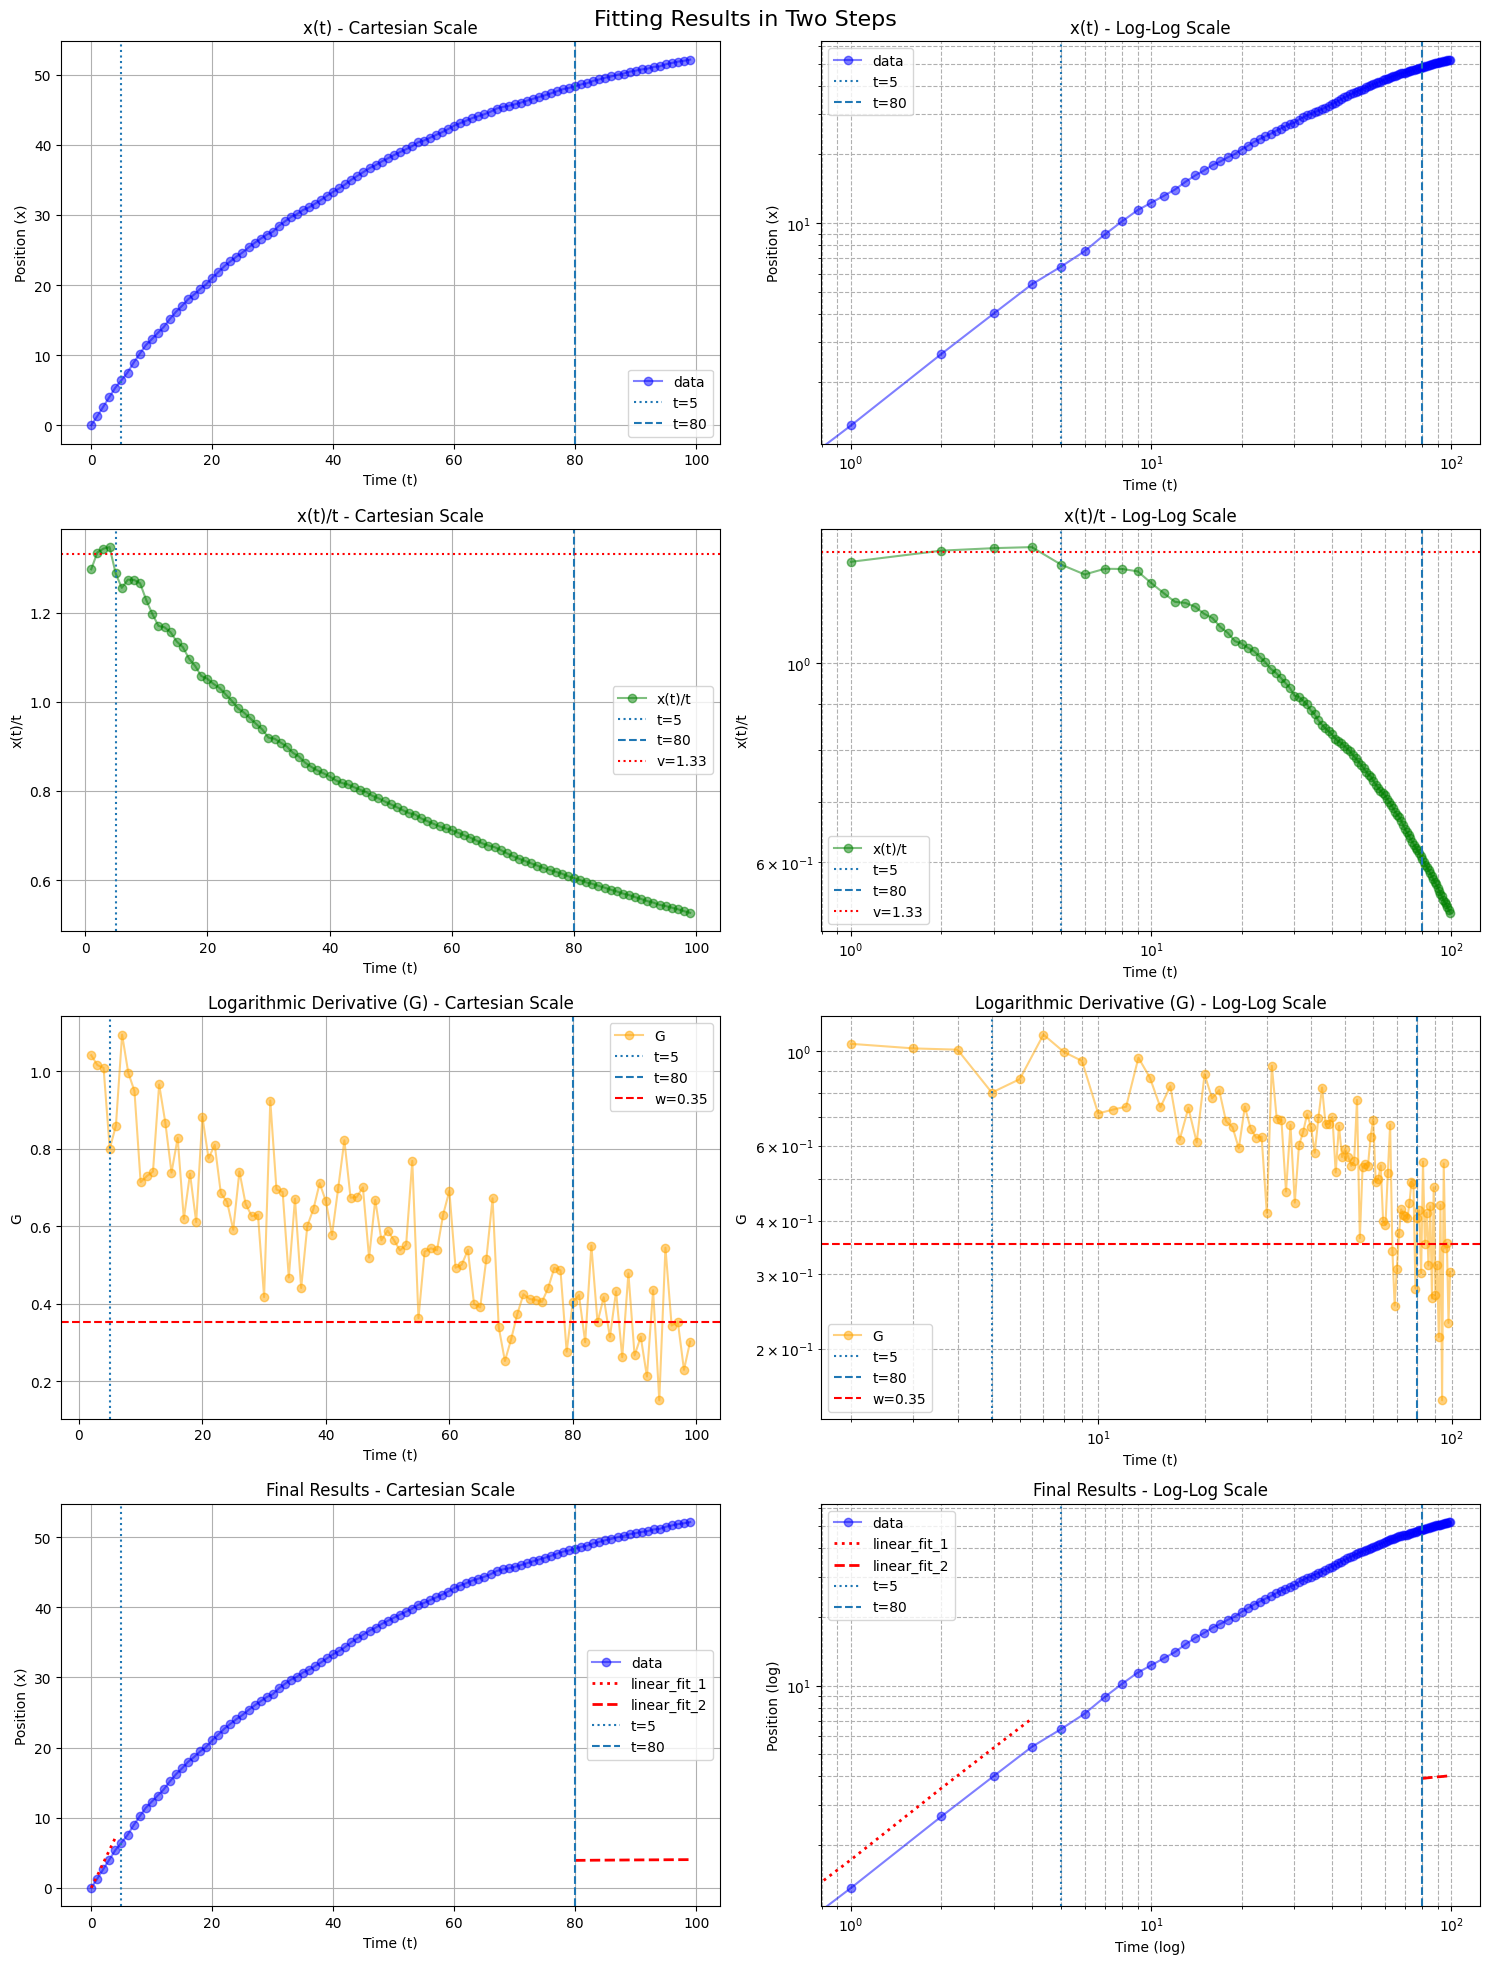

v= 1.330425 
w= 0.35196747235189385


In [13]:
# datas - en entrée de fonction
positions = [0.0, 1.297, 2.6693, 4.0299, 5.387, 6.4395, 7.5328, 8.9173, 10.1862, 11.3911, 12.2812, 13.1653, 14.0422, 15.1709, 16.1784, 17.0243, 17.9585, 18.6452, 19.4461, 20.0991, 21.0307, 21.8413, 22.6803, 23.3813, 24.0508, 24.6383, 25.3653, 26.0032, 26.6021, 27.1969, 27.5845, 28.4334, 29.0678, 29.6902, 30.1079, 30.6994, 31.083, 31.5991, 32.1477, 32.7472, 33.3032, 33.7815, 34.3552, 35.026, 35.5728, 36.1169, 36.6772, 37.089, 37.6143, 38.0543, 38.5098, 38.9433, 39.3522, 39.7683, 40.3439, 40.6137, 41.0069, 41.4032, 41.7925, 42.2454, 42.7391, 43.089, 43.4413, 43.8175, 44.0943, 44.3624, 44.7138, 45.1681, 45.3961, 45.5638, 45.7663, 46.0093, 46.2835, 46.5476, 46.8082, 47.0634, 47.3389, 47.6448, 47.9447, 48.114, 48.3599, 48.6145, 48.7944, 49.121, 49.3288, 49.5729, 49.7551, 50.0043, 50.1545, 50.4265, 50.5772, 50.7535, 50.8716, 51.1115, 51.1942, 51.4903, 51.6761, 51.8661, 51.9885, 52.1486]
deviations = [0.0, 14.50022037763538, 21.267551281472233, 26.37812741628666, 30.8760980533471, 33.85816503813821, 36.62937515383158, 40.178756336027455, 43.21774785386325, 45.97523834403059, 47.741343996162, 49.54222417201055, 51.384622399698436, 53.964594811689054, 55.699281624088464, 57.43501292338616, 59.13754456984503, 60.50131334904976, 62.08462043686774, 63.15303539173757, 64.53203512605076, 65.91844896772015, 67.47277296739367, 68.79472589021162, 69.87579852395632, 70.92685579602191, 72.50075072651867, 73.61290912441527, 74.80303720832055, 75.93566968421715, 76.49281443214099, 78.01924611556485, 78.91175706547124, 79.94398428875174, 80.59869141363627, 81.9106479014807, 82.69990635423396, 83.70426141595087, 84.79453923874179, 85.75172821675261, 87.06281565491103, 87.91754977108289, 89.07171623449517, 90.36682977729924, 91.40783938021394, 92.43724484421493, 93.17699930863724, 94.00665550374808, 94.85701416084086, 95.7506383869666, 96.72917504021635, 97.76147955667658, 98.43895953920477, 99.26796167500936, 100.50119319086872, 101.02154855430015, 101.71734784386231, 102.63503022729712, 103.31792024499956, 104.00609106605937, 105.11677426171659, 105.83932104373369, 106.64167456633274, 107.39614980878906, 107.99057462348605, 108.61293784001828, 109.33249146324836, 110.66216355372738, 111.27317288901904, 111.66317087365196, 112.15573050142532, 112.51225805888433, 113.03755538646463, 113.53061672624206, 114.04621174225575, 114.40676195243009, 114.94653125165729, 115.53767019010664, 116.2411090875808, 116.70299055293448, 117.13483671388427, 117.707073235851, 117.90580617018063, 118.34144480695944, 118.79468965639774, 119.40267537031212, 119.89216623279336, 120.44378971747832, 120.66261156525977, 121.2542980588708, 121.57860190081726, 121.95750955865657, 122.17870482796444, 122.37953696491776, 122.49082776420276, 123.29726885016267, 123.68462713202948, 124.22417788332518, 124.4460452073569, 124.96246443648924]

tmax = 100
time_step = 1
times = np.arange(0, tmax, time_step)


popt, pcov = fitting_in_superposition(positions, deviations, tmax, time_step, True)
v, D, w, tau, h = popt
print("v=",v, "\nw=",w)

bound_low = 5
bound_high = 80

v,w = fitting_in_two_steps(positions, times, bound_low, bound_high, True)
print("v=",v, "\nw=",w)

# .